In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import louvain
import episcanpy.api as epi

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
%config InlineBackend.figure_format='retina'

# Loading the Data

In [3]:
SCATAC_DIR = '../data/scATAC/peaks/'

In [4]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, var_names='gene_ids', cache=True)

var = pd.read_csv(SCATAC_DIR + 'var.csv')
scatac.var = var

obs = pd.read_csv(SCATAC_DIR + 'obs.csv')
scatac.obs = obs

AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 


CPU times: user 46.5 s, sys: 5min 57s, total: 6min 43s
Wall time: 7min 58s


In [5]:
scatac

AnnData object with n_obs × n_vars = 70461 × 506543 
    obs: 'Unnamed: 0', 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'ProjectUMAP1', 'ProjectUMAP2', 'ProjectClassification'
    var: 'Unnamed: 0', 'score', 'scoreQuantile', 'name', 'GC'

In [6]:
scatac.obs.head()

,Unnamed: 0,FRIP,TotalReads,Group,Barcode,initialClusters,UMAP1,UMAP2,Clusters,ProjectUMAP1,ProjectUMAP2,ProjectClassification
0,BMM_R1_19,0.556943,67260,BMMC_D5T1,TAGGAGGGTGCACTTA-1,Cluster1,9.028878,-3.070899,Cluster1,-7.257169,-3.767484,07_GMP
1,BMM_R1_21,0.541798,17154,BMMC_D5T1,CCTAAAGTCCGCCTAT-1,Cluster2,0.151454,13.363869,Cluster2,9.737446,-2.393460,22_CD4.M
2,BMM_R1_24,0.551778,38974,BMMC_D5T1,CCTAAAGAGAAATACC-1,Cluster3,-3.914717,-6.629660,Cluster3,1.359905,12.922869,02_Early.Eryth
3,BMM_R1_25,0.590287,38898,BMMC_D5T1,TAAACCGCACATTCTT-1,Cluster4,-2.434527,12.142631,Cluster4,11.522385,1.818643,24_CD8.CM
4,BMM_R1_26,0.626936,36546,BMMC_D5T1,TTGCCCACATTCGTCC-1,Cluster4,-1.765110,12.288043,Cluster4,10.663303,0.689267,24_CD8.CM


In [7]:
scatac.var.head()

,Unnamed: 0,score,scoreQuantile,name,GC
0,chr1_10262_10762,569.13025,0.730487,scATAC_1,0.668663
1,chr1_115474_115974,14.71841,0.404278,scATAC_2,0.397206
2,chr1_237503_238003,118.22647,0.688421,scATAC_3,0.461078
3,chr1_240798_241298,18.89871,0.391035,scATAC_4,0.477046
4,chr1_540713_541213,116.68542,0.611578,scATAC_6,0.502994


# Data Cleaning

In [8]:
scatac.obs.set_index('Unnamed: 0', inplace=True)

In [9]:
scatac.var.set_index('Unnamed: 0', inplace=True)

In [10]:
scatac.obs.rename(columns={'ProjectClassification': 'cell_type'}, inplace=True)

In [11]:
scatac.obsm['X_umap'] = scatac.obs[['ProjectUMAP1', 'ProjectUMAP2']].to_numpy()
scatac.obs.drop(['ProjectUMAP1', 'ProjectUMAP2'], axis=1, inplace=True)

In [12]:
scatac.obs['condition'] = scatac.obs['cell_type'].map(lambda a: 'stimulated' if a.endswith('Like') else 'control')

In [13]:
scatac.obs.head()

,FRIP,TotalReads,Group,Barcode,initialClusters,UMAP1,UMAP2,Clusters,cell_type,condition
Unnamed: 0,,,,,,,,,,
BMM_R1_19,0.556943,67260,BMMC_D5T1,TAGGAGGGTGCACTTA-1,Cluster1,9.028878,-3.070899,Cluster1,07_GMP,control
BMM_R1_21,0.541798,17154,BMMC_D5T1,CCTAAAGTCCGCCTAT-1,Cluster2,0.151454,13.363869,Cluster2,22_CD4.M,control
BMM_R1_24,0.551778,38974,BMMC_D5T1,CCTAAAGAGAAATACC-1,Cluster3,-3.914717,-6.629660,Cluster3,02_Early.Eryth,control
BMM_R1_25,0.590287,38898,BMMC_D5T1,TAAACCGCACATTCTT-1,Cluster4,-2.434527,12.142631,Cluster4,24_CD8.CM,control
BMM_R1_26,0.626936,36546,BMMC_D5T1,TTGCCCACATTCGTCC-1,Cluster4,-1.765110,12.288043,Cluster4,24_CD8.CM,control


In [14]:
scatac.var.head()

,score,scoreQuantile,name,GC
Unnamed: 0,,,,
chr1_10262_10762,569.13025,0.730487,scATAC_1,0.668663
chr1_115474_115974,14.71841,0.404278,scATAC_2,0.397206
chr1_237503_238003,118.22647,0.688421,scATAC_3,0.461078
chr1_240798_241298,18.89871,0.391035,scATAC_4,0.477046
chr1_540713_541213,116.68542,0.611578,scATAC_6,0.502994


Save the raw data:

In [15]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-raw.h5ad')

... storing 'Group' as categorical
... storing 'Barcode' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical
... storing 'cell_type' as categorical
... storing 'condition' as categorical


CPU times: user 8.7 s, sys: 4.47 s, total: 13.2 s
Wall time: 18.7 s


# Preprocessing

In [15]:
%time scatac = epi.pp.binarize(scatac, copy=True)

CPU times: user 1min 1s, sys: 1min 46s, total: 2min 48s
Wall time: 7min 29s


In [16]:
scatac

AnnData object with n_obs × n_vars = 70461 × 506543 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition'
    var: 'score', 'scoreQuantile', 'name', 'GC'
    obsm: 'X_umap'

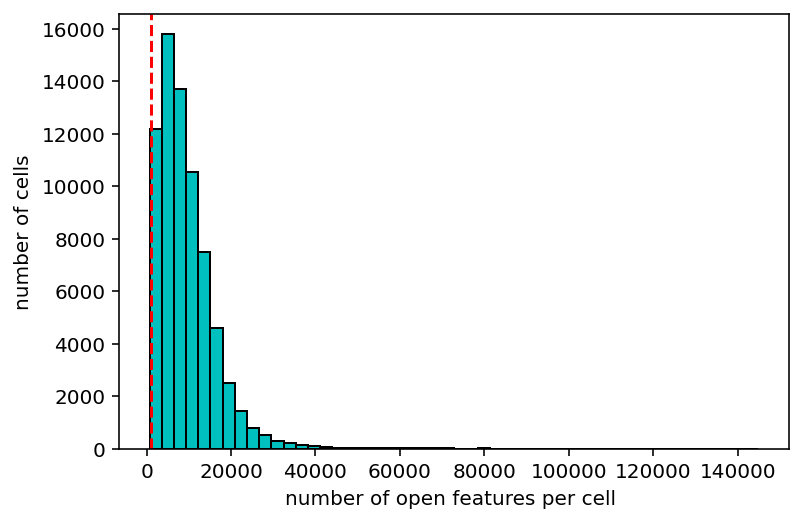

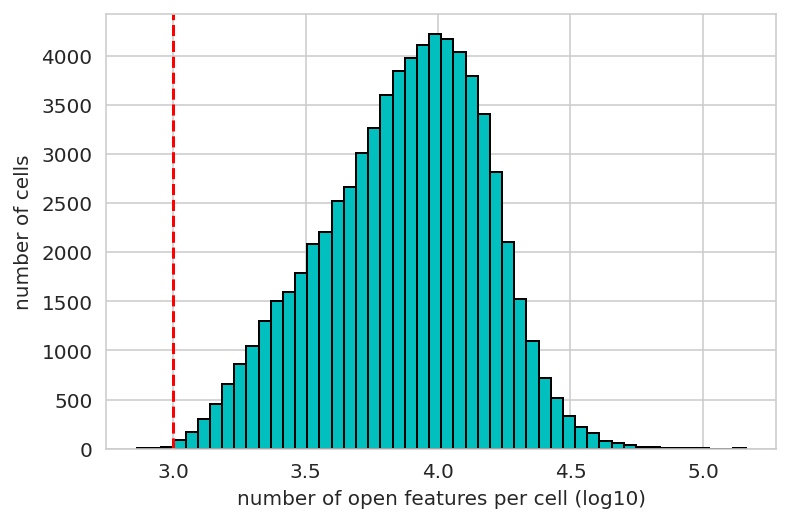

In [17]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=1000)
epi.pp.coverage_cells(scatac, binary=True, log=10, bins=50, threshold=1000)

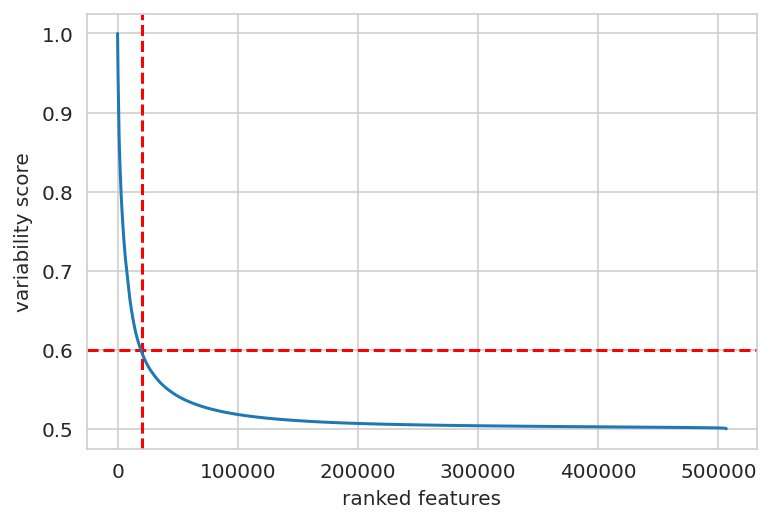

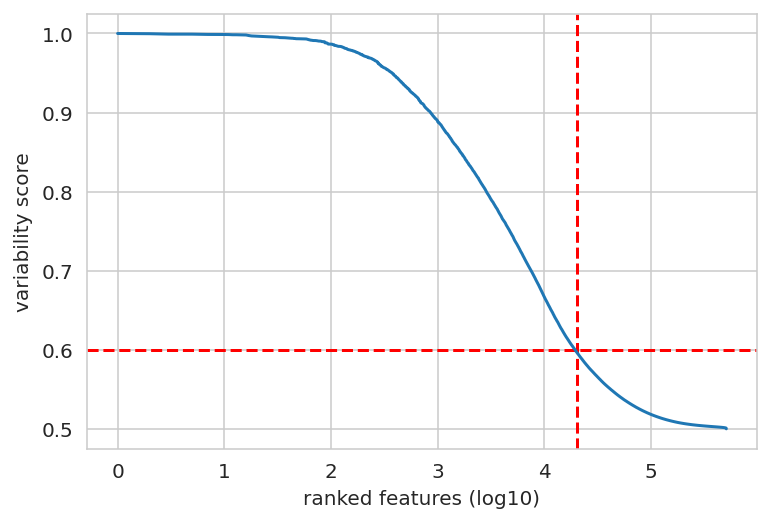

In [18]:
min_score_value = 0.6
nb_feature_selected = 20000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

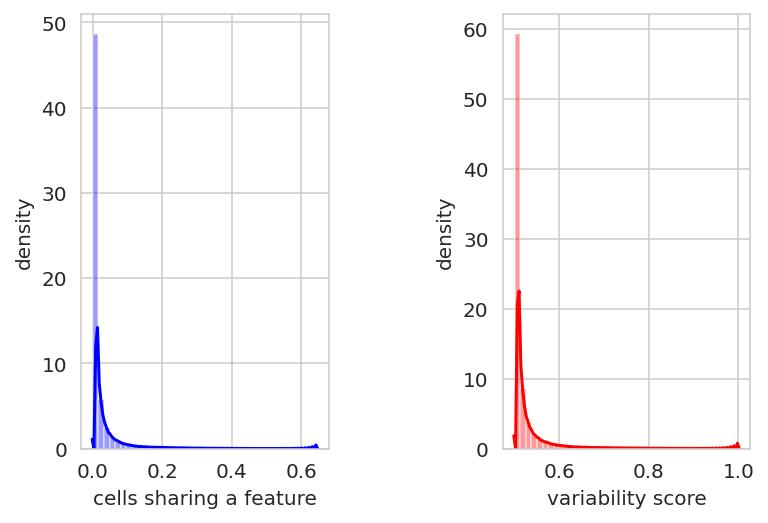

CPU times: user 23.8 s, sys: 2min 7s, total: 2min 31s
Wall time: 8min 12s


In [19]:
%time scatac = epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected, copy=True)

Save the binary peaks:

In [20]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')

Trying to set attribute `.obs` of view, making a copy.
... storing 'Group' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'Barcode' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'initialClusters' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'Clusters' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'condition' as categorical


CPU times: user 7.49 s, sys: 2min 14s, total: 2min 21s
Wall time: 8min 30s


In [21]:
%%time
epi.pp.normalize_per_cell(scatac)
epi.pp.log1p(scatac)

Trying to set attribute `.obs` of view, making a copy.


CPU times: user 7.04 s, sys: 57.4 s, total: 1min 4s
Wall time: 4min 6s


In [22]:
scatac

AnnData object with n_obs × n_vars = 70461 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features', 'n_counts'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    obsm: 'X_umap'

# Visualization

## UMAP using coordinates provided by the authors

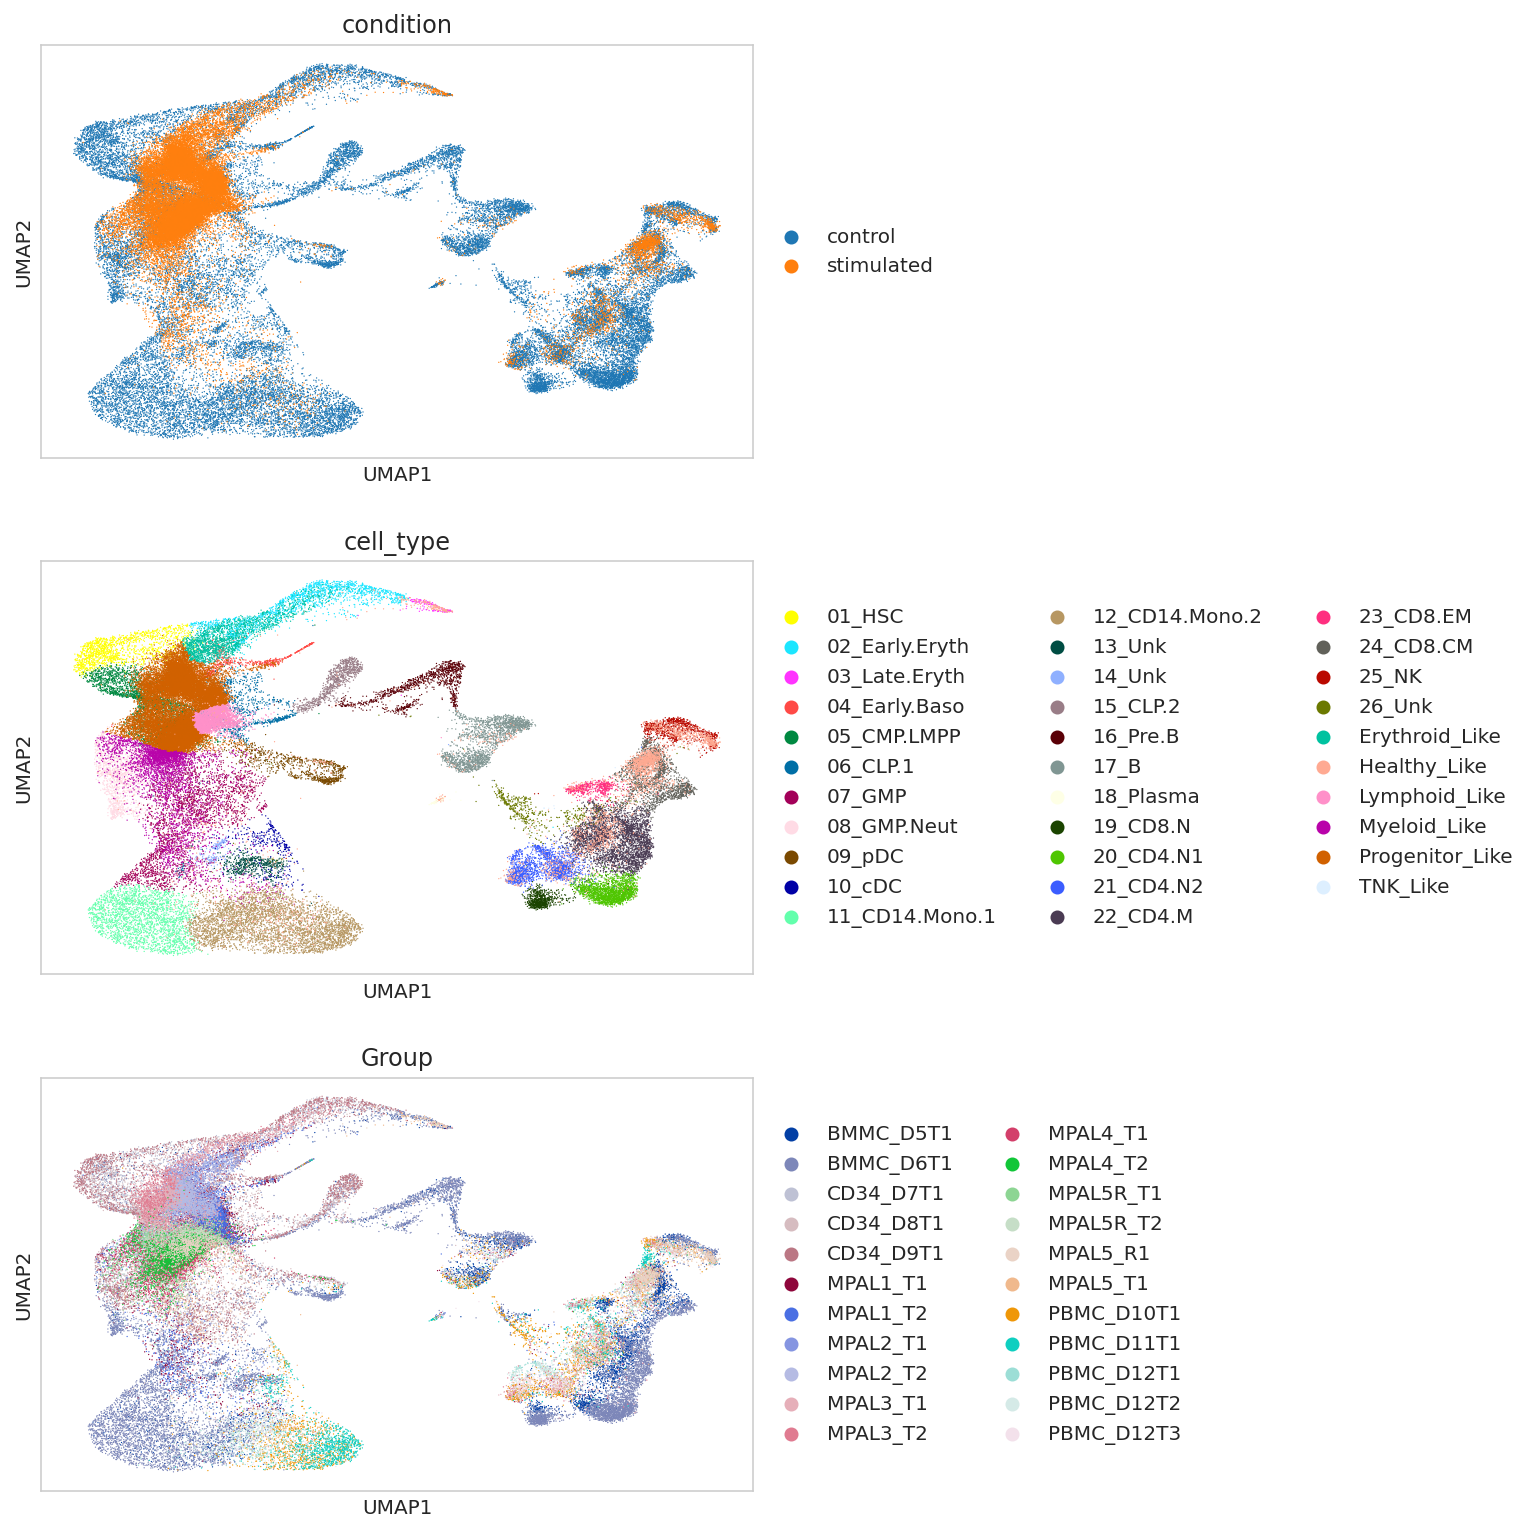

In [23]:
sc.pl.umap(scatac, color=['condition', 'cell_type', 'Group'], ncols=1)

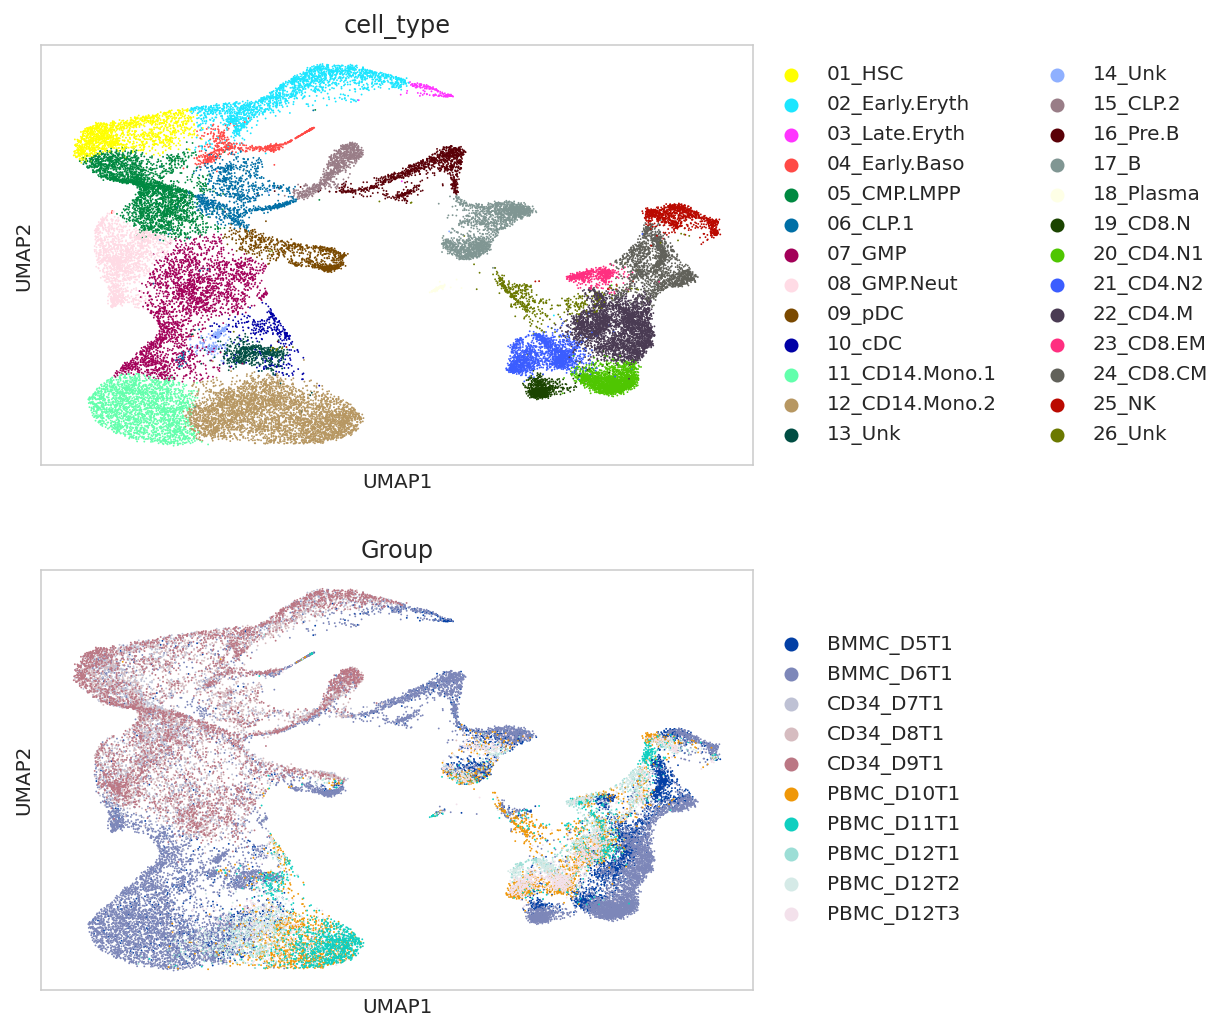

In [24]:
sc.pl.umap(scatac[scatac.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

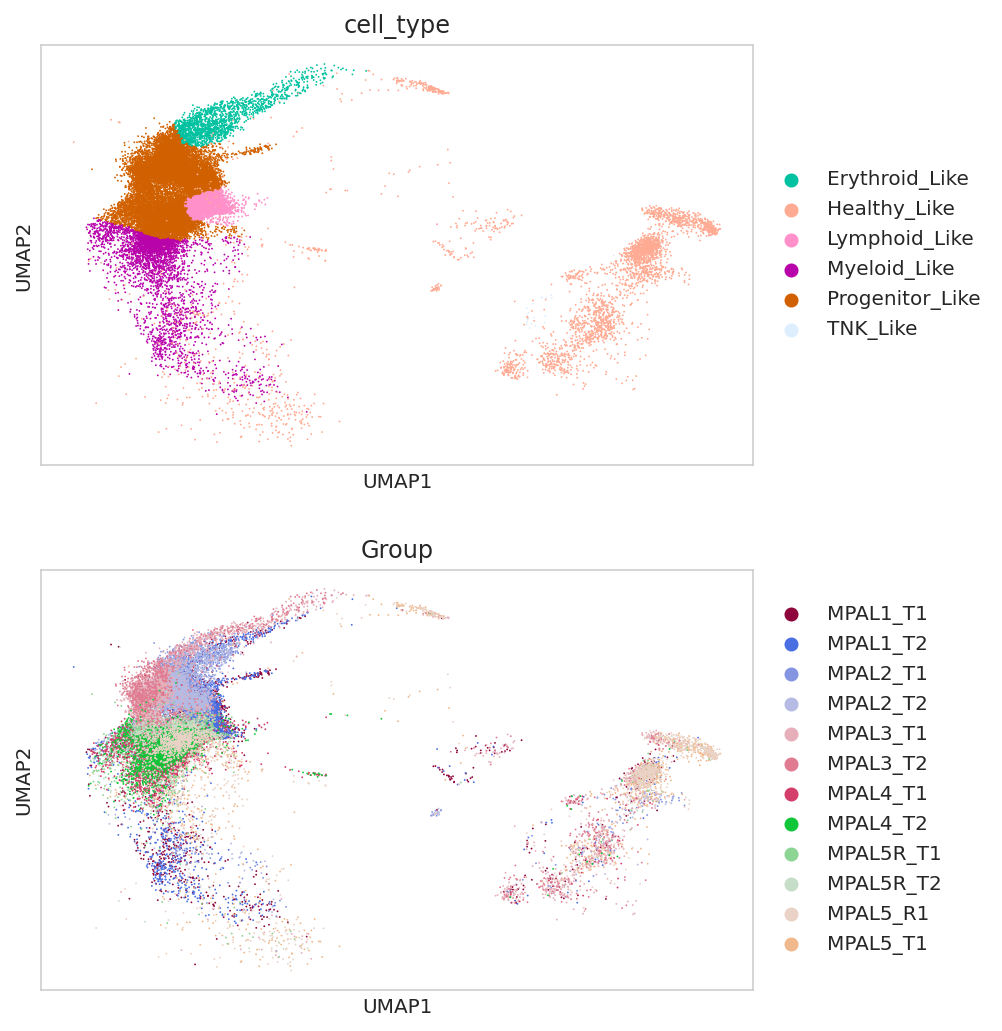

In [25]:
sc.pl.umap(scatac[scatac.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

# Save the result

In [26]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks.h5ad')

CPU times: user 1.28 s, sys: 1.7 s, total: 2.98 s
Wall time: 4.27 s
